### Import packages

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import os
import requests
from io import StringIO
import pymc as pm
import arviz as az
from tqdm import tqdm
import hssm
import random
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import shapiro
from scipy import stats

In [6]:
wald_prior_class = "log_normal_prior_centered"

### Import data and gambles

In [3]:
try:
    df_processed_experiment_data = pd.read_csv(
        "../data_preprocessing/processed_data/processed_experiment_data.csv"
    )
    #df_processed_experiment_data = pd.read_csv(
    #    "../data_preprocessing/processed_data/processed_reproduction_task_data.csv"
    #)
    print("Successfully loaded processed experiment data")
except FileNotFoundError:
    print("File not found. Please run the preprocessing pipeline first to generate 'processed_experiment_data.csv'.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Successfully loaded processed experiment data


In [4]:
par_ids = np.unique(df_processed_experiment_data['ParticipantID'])
print(df_processed_experiment_data.columns)

Index(['ParticipantID', 'BlockNumber', 'ExperimentRoundNumber',
       'ExperimentGambleNumber', 'LotteryLeft', 'LotteryRight', 'GambleChoice',
       'ResponseTimeGamble', 'GambleSecondaryChoices',
       'GambleSecondaryChoicesTimes', 'GamblePresetDeadline',
       'GambleFinalDeadline', 'FullScreenExited', 'ReproducedTime',
       'MissedMaxDeadline', 'SubjectiveDifficulty',
       'ResponseTimeSubjectiveDifficulty',
       'ResponseTimeSubmitAnswersQuestionnaire'],
      dtype='object')


In [7]:
# Experiment version
exp_version = 2

#Nextcloud credentials
username = 'algarrid'
password = 'faunistico'

file_url = (
    'https://cloud.ilabt.imec.be/remote.php/dav/files/'+
    'af741990-37f9-103d-9441-9bec5c4808a7/ExperimentsData/'+
    'cwir_dataset/stimuli/gambles.csv'            
)

response = requests.get(file_url, auth=(username, password))

# Check if the request was successful
if response.status_code == 200:
    # Stream the content directly into a pandas DataFrame
    csv_content = StringIO(response.text)
    df_gambles = pd.read_csv(csv_content)

    # Now `df` is your DataFrame containing the CSV data
    print("Gambles downloaded")  # Example: print the first few rows
else:
    print(f"Failed to retrieve the file. Status code: {response.status_code}")


idata_wald = az.from_netcdf(f"../model_fitting/idata_wald_{wald_prior_class}.nc")

wald_post = idata_wald.posterior

Gambles downloaded


## Classify participants

In [8]:
# 1) Posterior for the difference (beta1 - beta2) for each subject
diff = wald_post["indi_beta1"] - wald_post["indi_beta2"]   # dims: chain, draw, subject

# 2) Probability that (beta1 - beta2) < 0 for each subject
prob_below_zero = (diff < 0).mean(dim=("chain", "draw"))

prob_above_zero = (diff > 0).mean(dim=("chain", "draw"))
# prob_below_zero is a DataArray with dim "subject"


mask_negative = prob_below_zero > 0.95

mask_positive = prob_above_zero > 0.95

# Subjects that satisfy the criterion
par_ids_negative_delta_par = prob_below_zero["subject"].values[mask_negative.values]

par_ids_positive_delta_par = prob_above_zero["subject"].values[mask_positive.values]

par_ids_low_delta_par = []

for par in par_ids:
    if par not in par_ids_negative_delta_par and par not in par_ids_positive_delta_par:
        par_ids_low_delta_par.append(par)

## Data analysis

##### What are the ranges of average, median and IQR of the experienced target time, and the ratio between RT and target time,  across participants?

In [9]:
iqr_experienced_TT = []
median_experienced_TT = []
mean_experienced_TT = []

std_experienced_TT = []

iqr_ratios = []
median_ratios = []
mean_ratios = []


for par in par_ids:
    df_par = df_processed_experiment_data[df_processed_experiment_data["ParticipantID"]==par]
    
    n_rounds = np.unique(df_par['ExperimentRoundNumber'])

    target_time_list = []

    ratios_list = []
    
    for r in n_rounds:
        
        df_round = df_par[df_par["ExperimentRoundNumber"]==r]

        rt = df_round["ResponseTimeGamble"].iloc[0]

        if df_round["MissedMaxDeadline"].iloc[0] == 0:
            tt = df_round["GambleFinalDeadline"].iloc[0]
        else:
            tt = df_round["ResponseTimeGamble"].iloc[0]

        ratios_list.append(rt/tt)

        target_time_list.append(tt)

    mean_experienced_TT.append(np.mean(target_time_list))
    std_experienced_TT.append(np.std(target_time_list))
    median_experienced_TT.append(np.median(target_time_list))

    q1 = np.percentile(target_time_list, 25)
    q3 = np.percentile(target_time_list, 75)
    iqr = q3 - q1

    iqr_experienced_TT.append(iqr)

    mean_ratios.append(np.mean(ratios_list))
    median_ratios.append(np.median(ratios_list))

    q1_rat = np.percentile(ratios_list, 25)
    q3_rat = np.percentile(ratios_list, 75)
    iqr_rat = q3_rat - q1_rat

    iqr_ratios.append(iqr_rat)

    print(f"Participant {par} experienced a mean target time of: {np.mean(target_time_list)}")
    print(f"Participant {par} experienced a median target time of: {np.median(target_time_list)}")
    print(f"Participant {par} had an target time IQR equal to: {iqr}")
    print("------------------------------------------------------------------------------------")


print(f"Range of mean RT/TT experienced: [{min(mean_ratios)}, {max(mean_ratios)}]")
print(f"Range of median RT/TT experienced: [{min(median_ratios)}, {max(median_ratios)}]")       
print(f"Range of IQRs of RT/TT experienced: [{min(iqr_ratios)}, {max(iqr_ratios)}]") 


print(f"Range of mean target time experienced: [{min(mean_experienced_TT)}, {max(mean_experienced_TT)}]")
print(f"Range of median target time experienced: [{min(median_experienced_TT)}, {max(median_experienced_TT)}]")       
print(f"Range of IQRs of target time experienced: [{min(iqr_experienced_TT)}, {max(iqr_experienced_TT)}]")    



Participant 2 experienced a mean target time of: 8.108364374999702
Participant 2 experienced a median target time of: 8.0
Participant 2 had an target time IQR equal to: 4.0
------------------------------------------------------------------------------------
Participant 3 experienced a mean target time of: 8.0125
Participant 3 experienced a median target time of: 8.0
Participant 3 had an target time IQR equal to: 4.0
------------------------------------------------------------------------------------
Participant 5 experienced a mean target time of: 7.9875
Participant 5 experienced a median target time of: 8.0
Participant 5 had an target time IQR equal to: 4.0
------------------------------------------------------------------------------------
Participant 9 experienced a mean target time of: 7.9748427672955975
Participant 9 experienced a median target time of: 8.0
Participant 9 had an target time IQR equal to: 4.0
--------------------------------------------------------------------------

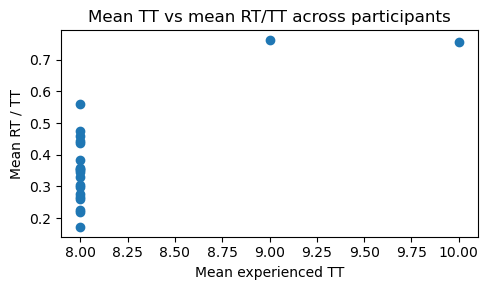

In [5]:
plt.figure(figsize=(5, 3)) 
plt.title("Mean TT vs mean RT/TT across participants")
plt.scatter(median_experienced_TT, mean_ratios)
plt.xlabel("Mean experienced TT")
plt.ylabel("Mean RT / TT")
plt.tight_layout()
plt.show()

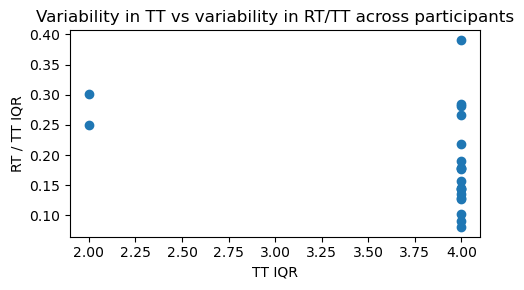

In [6]:
plt.figure(figsize=(5, 3)) 
plt.title("Variability in TT vs variability in RT/TT across participants")
plt.scatter(iqr_experienced_TT, iqr_ratios)
plt.xlabel("TT IQR")
plt.ylabel("RT / TT IQR")
plt.tight_layout()
plt.show()

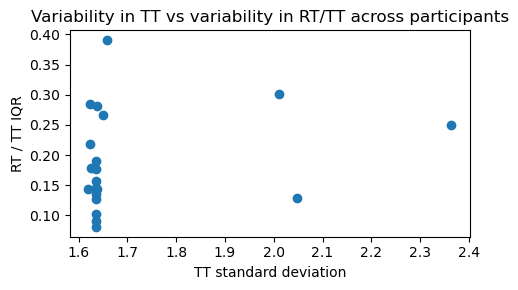

In [7]:
plt.figure(figsize=(5, 3)) 
plt.title("Variability in TT vs variability in RT/TT across participants")
plt.scatter(std_experienced_TT, iqr_ratios)
plt.xlabel("TT standard deviation")
plt.ylabel("RT / TT IQR")
plt.tight_layout()
plt.show()

##### For how many trials was it the case that the maximum deadline (10 seconds) was missed?

In [8]:
total_missed_trials_count = 0

for par in par_ids:
    df_par = df_processed_experiment_data[df_processed_experiment_data["ParticipantID"]==par]
    
    n_rounds = np.unique(df_par['ExperimentRoundNumber'])

    missed_10second_deadline_trials_list_counter = 0
    
    for r in n_rounds:
        
        df_round = df_par[df_par["ExperimentRoundNumber"]==r]

        if df_round["MissedMaxDeadline"].iloc[0] == 1:
            missed_10second_deadline_trials_list_counter+=1
            total_missed_trials_count+=1

    print(f"Participant {par}, had {missed_10second_deadline_trials_list_counter} trials for which the maximum deadline was missed")

print("------------------------------------------------------------------------")
print(f"In {(total_missed_trials_count/len(df_processed_experiment_data))*100} % of the trials, the maximum deadline was surpassed")
print("------------------------------------------------------------------------")

Participant 1, had 1 trials for which the maximum deadline was missed
Participant 2, had 1 trials for which the maximum deadline was missed
Participant 3, had 0 trials for which the maximum deadline was missed
Participant 4, had 0 trials for which the maximum deadline was missed
Participant 5, had 0 trials for which the maximum deadline was missed
Participant 6, had 0 trials for which the maximum deadline was missed
Participant 7, had 13 trials for which the maximum deadline was missed
Participant 8, had 1 trials for which the maximum deadline was missed
Participant 9, had 0 trials for which the maximum deadline was missed
Participant 10, had 14 trials for which the maximum deadline was missed
Participant 11, had 0 trials for which the maximum deadline was missed
Participant 12, had 0 trials for which the maximum deadline was missed
Participant 13, had 0 trials for which the maximum deadline was missed
Participant 15, had 0 trials for which the maximum deadline was missed
Participant 1

##### Are Reaction times (or their logarithm) normally distributed?

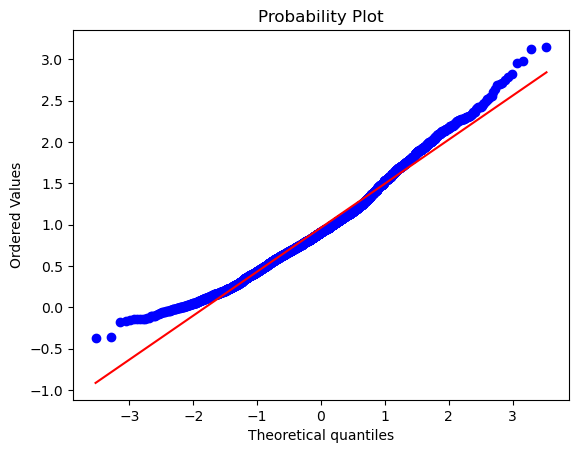

In [25]:
stats.probplot(np.log(df_processed_experiment_data["ResponseTimeGamble"].values), dist="norm", plot=plt)
plt.show()



In [17]:
stat, p = shapiro(np.log(df_processed_experiment_data["ResponseTimeGamble"].values))

print("W statistic:", stat)
print("p-value:", p)

alpha = 0.05
if p > alpha:
    print("Fail to reject H0: log(RT) data look normally distributed (at α = 0.05).")
else:
    print("Reject H0: log(RT) data do not look normally distributed (at α = 0.05).")

W statistic: 0.9814167022950671
p-value: 1.4672745820241763e-20
Reject H0: log(RT) data do not look normally distributed (at α = 0.05).


(array([  2.,   0.,   0.,   0.,   0.,   2.,   8.,   5.,   8.,  12.,  23.,
         20.,  21.,  32.,  38.,  40.,  44.,  40.,  45.,  39.,  45.,  61.,
         54.,  65.,  60.,  62.,  69.,  84.,  88.,  96., 101.,  98.,  88.,
        110.,  86.,  93., 102., 100.,  88.,  81.,  90.,  88.,  86.,  76.,
         70.,  65.,  44.,  52.,  40.,  43.,  47.,  35.,  45.,  29.,  46.,
         33.,  39.,  26.,  41.,  33.,  29.,  27.,  19.,  18.,  30.,  23.,
         12.,  21.,  10.,  12.,  16.,  18.,  12.,   6.,  11.,  12.,   7.,
          3.,   2.,   5.,   2.,   1.,   3.,   1.,   1.,   1.,   1.,   2.,
          1.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          2.]),
 array([-0.37019449, -0.33499275, -0.299791  , -0.26458926, -0.22938751,
        -0.19418576, -0.15898402, -0.12378227, -0.08858053, -0.05337878,
        -0.01817704,  0.01702471,  0.05222646,  0.0874282 ,  0.12262995,
         0.15783169,  0.19303344,  0.22823519,  0.26343693,  0.29863868,
         0.33384042,  0.36

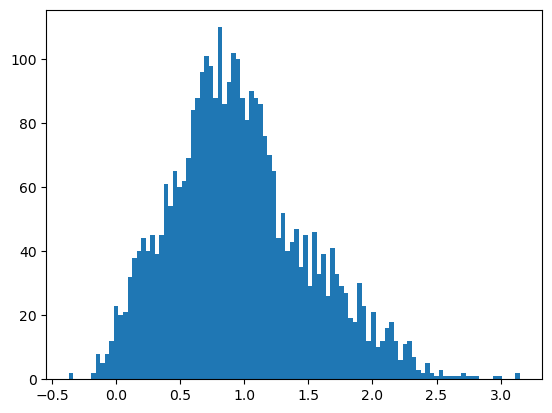

In [19]:
plt.hist(np.log(df_processed_experiment_data["ResponseTimeGamble"].values), bins = 100)

##### Did the difference in the gambles attributes (dX and dP) determined the reaction times?

In [32]:
for i in range(len(df_processed_experiment_data)):
    
    df_row = df_processed_experiment_data.iloc[i]
    gamble_num = df_row["ExperimentGambleNumber"]

    df_gamble = df_gambles[df_gambles["GambleNumber"] == gamble_num]

    df_processed_experiment_data.loc[i, "dX"] = df_gamble["dX"].iloc[0]
    df_processed_experiment_data.loc[i, "dP"] = df_gamble["dP"].iloc[0]
    df_processed_experiment_data.loc[i, "dEV"] = df_gamble["dEV"].iloc[0]

In [41]:
import statsmodels.formula.api as smf

# (Optional but recommended) center predictors to make the interaction easier to interpret
df = df_processed_experiment_data.copy()
df["dX_c"] = df["dX"] - df["dX"].mean()
df["dP_c"] = df["dP"] - df["dP"].mean()
df["dEV_c"] = df["dEV"] - df["dEV"].mean()


df["logRT"] = np.log(df["ResponseTimeGamble"])

# Linear mixed-effects model:
# - DV: ResponseTimeGamble
# - Fixed effects: dX_c, dP_c, and their interaction dX_c:dP_c
# - Random intercepts for ParticipantID
model = smf.mixedlm(
    #"logRT ~ dX_c + dP_c + dEV_c",
    "logRT ~ dX_c*dP_c",
    df,
    groups=df["ParticipantID"]   # random intercept per participant
)

result = model.fit(method="lbfgs")
print(result.summary())


import numpy as np

# Fixed-effects design matrix (X) and fixed-effect coefficients (beta)
X = result.model.exog
beta = result.fe_params.values

# Predicted values from fixed effects only
y_fixed = X @ beta

# Variance components
var_fixed = np.var(y_fixed, ddof=1)           # variance of fixed-effect part
var_random = float(result.cov_re.iloc[0, 0])  # random intercept variance (Group Var)
var_resid = result.scale                      # residual variance (Scale)

# Marginal and conditional R²
R2_marginal = var_fixed / (var_fixed + var_random + var_resid)
R2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_resid)

print("Marginal R² (fixed effects):", R2_marginal)
print("Conditional R² (fixed + random):", R2_conditional)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: logRT     
No. Observations: 3350    Method:             REML      
No. Groups:       21      Scale:              0.1144    
Min. group size:  153     Log-Likelihood:     -1204.9602
Max. group size:  160     Converged:          Yes       
Mean group size:  159.5                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.951    0.090  10.557 0.000  0.775  1.128
dX_c         -0.003    0.000 -15.901 0.000 -0.003 -0.002
dP_c         -0.003    0.000 -12.778 0.000 -0.003 -0.002
dX_c:dP_c    -0.000    0.000  -8.164 0.000 -0.000 -0.000
Group Var     0.170    0.160                            

Marginal R² (fixed effects): 0.03908601858631879
Conditional R² (fixed + random): 0.6133156086090311
